In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy 
import json
import networkx as nx
import pulp

from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize

In [2]:
# Pulser imports
import pulser
from pulser import Pulse, Sequence, Register
from pulser.devices import MockDevice,DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform, ConstantWaveform, RampWaveform, BlackmanWaveform
from pulser_simulation import QutipEmulator, SimConfig



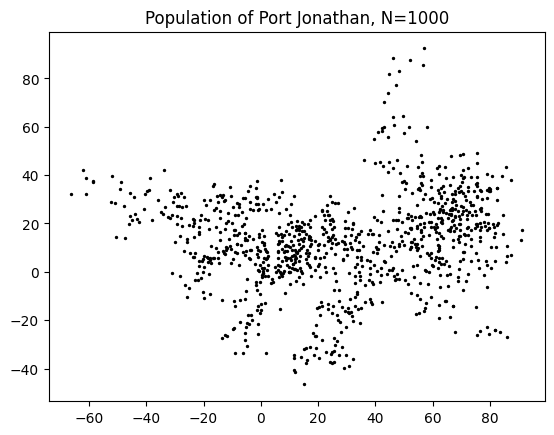

In [3]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[7]

with open('./data/population_{}.json'.format(city_name),'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, s=2, facecolor='black')
plt.title('Population of {}, N={}'.format(city_name, len(x)))
population_data = [[x_p,y_p] for x_p,y_p in zip(x,y)]

In [4]:
def evaluate_coverage(data, placement, R_dist):
    x = np.array(data['x'])
    y = np.array(data['y'])
    B = len(x)
    coords = np.array([[x[i], y[i]] for i in range(len(x))]) # x-y coordinates of houses
    cost = 0
    for i in range(len(placement)):
        coord_i = np.array([placement[i]]) # position of the ith antenna
        for j in range(len(placement)):
            coord_j = np.array([placement[j]]) # position of the jth antenna
            if i != j:
                dist = scipy.spatial.distance.cdist(coord_i, coord_j)
                if dist < (2 + 1e-3)*R_dist: # checking whether distance between ith and jth < 2R
                    cost += -B # penalising the cost function.


        dist = scipy.spatial.distance.cdist(coord_i, coords) # checking the distance between ith antenna and all houses.
        cov = np.sum(dist < R_dist) # checking whether the distance < R
        cost += cov # maximising cost function

    if cost < 0:
        return -np.inf
    else:
        return cost
    
R_antennas = 25

K-Means Lattice Generation

In [5]:
kmeans = KMeans(n_clusters=7, random_state=0)
clusters = kmeans.fit_predict(population_data)
centers = kmeans.cluster_centers_
antenna_pos = centers.copy()

Text(0.5, 1.0, 'Population of Port Jonathan, N=1000')

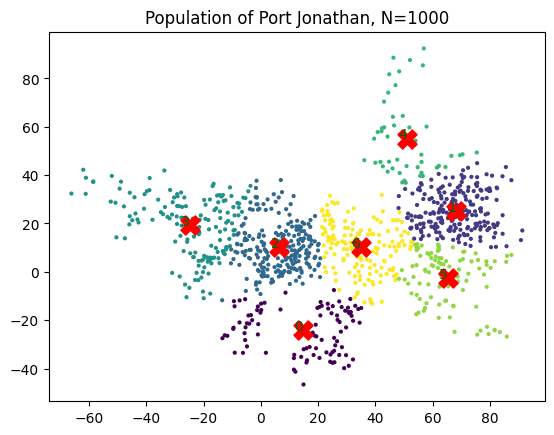

In [6]:
params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, c=clusters, s=4, cmap='viridis', label='Data Points')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=190, marker='X', label='Centroids')
for i, (w, z) in enumerate(zip(centers[:,0], centers[:,1])):
    plt.text(w, z, str(i), fontsize=10, ha='right', color='darkgreen')
plt.title('Population of {}, N={}'.format(city_name, len(x)))


Graph Generation

In [7]:
z_coverage = np.zeros(len(antenna_pos))
coords = np.array([[x[i], y[i]] for i in range(len(x))])
for i in range(len(antenna_pos)):
    # val_y = y_test[i,j]
    start = np.array(antenna_pos[i])
    # print(start)
    dist = scipy.spatial.distance.cdist(np.array([start]), coords)
    truth_table = (dist <= R_antennas)
    cov = np.sum(truth_table)
    z_coverage[i] = cov

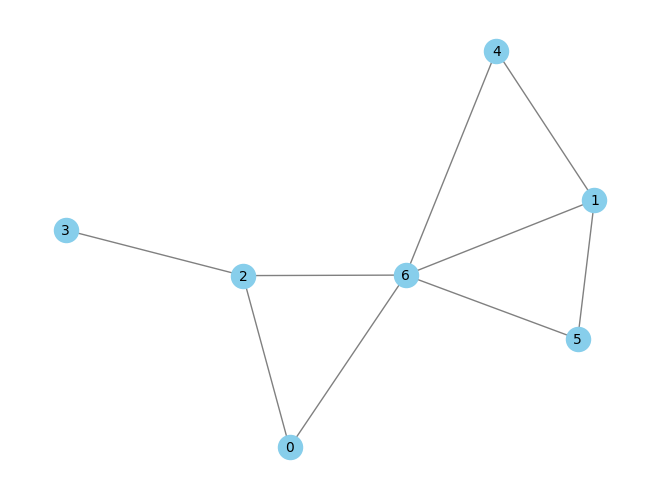

In [8]:
pairwise_dist = pdist(np.array(antenna_pos))
distance_mtrx = squareform(pairwise_dist)

# Create a graph
G = nx.Graph()

# Add nodes with positions
for i, (x, y) in enumerate(antenna_pos):
    G.add_node(i, pos=(x, y),weight=z_coverage[i])

# Add edges based on distance threshold
threshold = 2*R_antennas
for i in range(len(antenna_pos)):
    for j in range(i + 1, len(antenna_pos)):
        if distance_mtrx[i, j] < threshold:
            G.add_edge(i, j)

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=300, edge_color='gray', font_size=10)
G

UDG embedding

In [9]:
coords = antenna_pos.copy()
val = np.min(pdist(coords))
coords *= 5/val

In [10]:
device_used = DigitalAnalogDevice
seed = 100

In [11]:
Q = squareform(device_used.interaction_coeff / pdist(coords)**6)
r = 2*R_antennas*5/val
omega_rb = device_used.interaction_coeff/r**6


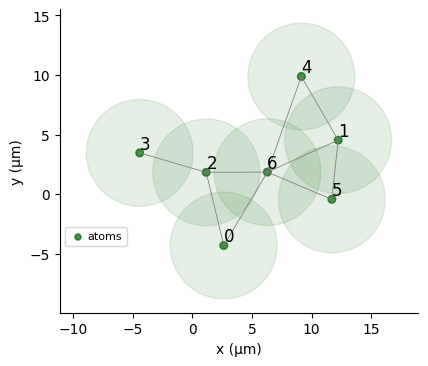

In [12]:
qubits = dict(enumerate(coords))
reg = Register(qubits)
R =  np.median(Q[Q>0].flatten())
reg.draw(
    blockade_radius = device_used.rydberg_blockade_radius(omega_rb),
    draw_graph = True,
    draw_half_radius = True, 
)

Adiabatic Evolution to solve MIS

In [13]:
# Set time values
t_rise = 500 # we need to set these values
t_sweep = 1500
t_fall = 500

In [14]:
omega_max = np.median(Q[Q>0].flatten())
delta_0 = -3*omega_max
delta_f = 3*omega_max

In [15]:
# Set the pulse
rise = Pulse.ConstantDetuning(
    amplitude=RampWaveform(duration=t_rise, start=0.0, stop=omega_max), detuning=delta_0, phase=0.0
)

sweep = Pulse.ConstantAmplitude(
    amplitude=omega_max, detuning=RampWaveform(duration=t_sweep, start=delta_0, stop=delta_f), phase=0.0
)

fall = Pulse.ConstantDetuning(
    amplitude=RampWaveform(duration=t_fall, start=omega_max, stop=0.0), detuning=delta_f, phase=0.0
)

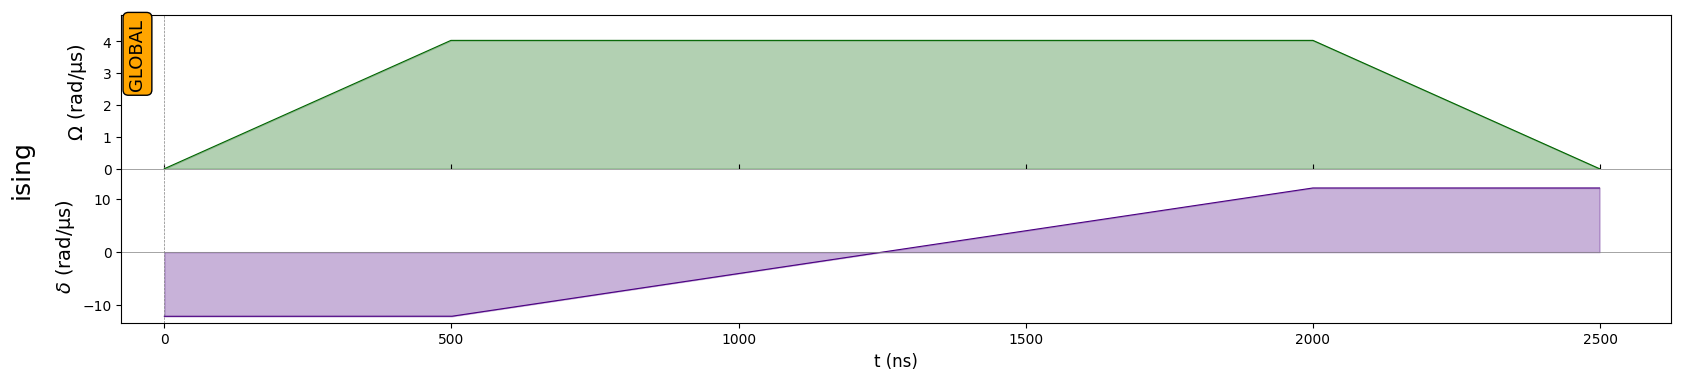

In [16]:
# Draw the pulse
seq = Sequence(reg, device_used)
seq.declare_channel("ising", "rydberg_global")
seq.add(rise, "ising", "no-delay")
seq.add(sweep, "ising", "no-delay")
seq.add(fall, "ising", "no-delay")
seq.draw()

In [17]:
# Set noise configurations
noise_config = {
    "noiseless": None,
    "noisy": SimConfig(
        noise = ("SPAM", "dephasing", "doppler"),
        eta = 0.8,
        temperature = 1000,
        runs = 50,
    )
}

In [18]:
# Set simulator
simulator = QutipEmulator.from_sequence(
    sequence = seq,
    sampling_rate = 0.01,
    with_modulation = False,
    config = noise_config["noiseless"],
)

simulator.show_config()
results = simulator.run(progress_bar = True)
count_dict = results.sample_final_state(N_samples = 1000)

Options:
----------
Number of runs:        15
Samples per run:       5
12.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.03s. Est. time left: 00:00:00:00
32.0%. Run time:   0.05s. Est. time left: 00:00:00:00
40.0%. Run time:   0.07s. Est. time left: 00:00:00:00
52.0%. Run time:   0.10s. Est. time left: 00:00:00:00
60.0%. Run time:   0.11s. Est. time left: 00:00:00:00
72.0%. Run time:   0.18s. Est. time left: 00:00:00:00
80.0%. Run time:   0.21s. Est. time left: 00:00:00:00
92.0%. Run time:   0.32s. Est. time left: 00:00:00:00
Total run time:   0.36s


In [19]:
# Check results
print(count_dict)

Counter({'1001110': 472, '1101000': 128, '1000110': 84, '0010110': 77, '1001100': 33, '0110000': 32, '1001010': 32, '0101000': 26, '1100000': 23, '0001010': 16, '0000110': 15, '0001100': 12, '0001110': 11, '1000100': 11, '0000001': 8, '0001001': 6, '1000010': 6, '0001101': 3, '0000101': 2, '0010010': 2, '0010100': 1})


In [20]:
state = max(count_dict, key=count_dict.get)
posindx= np.where(np.array(list(state)) =='1')
optimal_pos = antenna_pos[posindx]
evaluate_coverage(data,optimal_pos,R_antennas)

546

Classical post-processing for finding maximum coverage

In [21]:
most_frequent = {k:v for k, v in count_dict.items() if v > 0}
C = dict(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True))
bitstrings = list(C.keys())   
coverage =  {}
for bitstring in bitstrings:
    positions = [i for i, bit in enumerate(bitstring) if bit == '1']
    grid_ind_set = np.array(antenna_pos)[positions]
    c = evaluate_coverage(data, grid_ind_set, 25)
    coverage[str(positions)] = c

In [22]:
import csv
import ast

k =  max(coverage,key=coverage.get)
pos=antenna_pos[ast.literal_eval(k)]
with open('results.csv', mode='a+', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    # writer.writerow(['Grid Point', 'Location', 'Max-coverage'])

    writer.writerow([city_name,k,pos,coverage[k]])